# Ppromptcap-coco-vqa
Reference link [here](https://huggingface.co/vqascore/promptcap-coco-vqa)

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import pprint
import pandas as pd

True
NVIDIA GeForce RTX 3090


## Data loading

Check current directory

In [2]:
import os
os.getcwd()

'/home/arnau/tfg/GED-TFG'

Load JSON file and show a data sample item

In [3]:
direc = '/media/arnau/PEN/TFG/train/'
direcv = '/media/arnau/PEN/TFG/val/'

with open('./data/imgs_w_txt_ocr.json') as user_file:
  imgs_w_txt = json.load(user_file)

In [4]:
k = "VizWiz_train_00014833.jpg"
v = imgs_w_txt[k]

print(f"Key: {k}\n")
print("Value:\n")
pprint.pprint(v)


Key: VizWiz_train_00014833.jpg

Value:

{'answerable': 1.0,
 'flaws': [True, True, True, False, False, False, False, True],
 'ocr': {'acc': [0.005366372089468023,
                 0.002742848242573078,
                 0.002708727376418118,
                 0.0013632564777301401],
         'bboxs': [[[295, 418], [602, 418], [602, 491], [295, 491]],
                   [[190, 475], [657, 475], [657, 555], [190, 555]],
                   [[322, 560], [602, 560], [602, 674], [322, 674]],
                   [[156, 717], [705, 717], [705, 891], [156, 891]]],
         'text': ['au A4ja4l', '0fu4 ) oudannk', 'Aaa', 'TateR']},
 'question': 'What is in this bottle?',
 'recognizable': 1.0}


## Model loading
Load VQA model  
More models found [here](https://github.com/allenai/unifiedqa)

In [5]:
from promptcap import PromptCap_VQA

# QA model support all UnifiedQA variants. e.g. "allenai/unifiedqa-v2-t5-large-1251000"
vqa_model = PromptCap_VQA(promptcap_model="vqascore/promptcap-coco-vqa", 
                          qa_model="allenai/unifiedqa-t5-base")

if torch.cuda.is_available():
  vqa_model.cuda()

vqascore/promptcap-coco-vqa
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Helpers

Auxiliary function for plotting images

In [6]:
def plot_img(full_img_path):
  """
  Given an image path, this functions plots the image.
  """

  plt.figure(figsize=(3,3))
  img = cv2.imread(full_img_path)
  imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(imgc)
  plt.axis('off')
  plt.show()

## Testing the model 
See how the model performs We feed the model with an image and a qesution. We can also provide OCR inputs. Then the model will give an answer to the question.

### Small test with some images
(Images from train set)

In [7]:
# Take 3 random images
test_samples = random.sample(list(imgs_w_txt.keys()), 3)

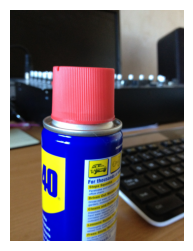

Question: Is this WD40, or is it stuff that's supposed to calm a cat down if it's getting stressed? A choice, thanks.
No OCR answer: WD40
OCR answer: drivee


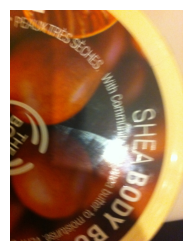

Question: Hi this is the top side night.  Can you see the flavor night?
No OCR answer: yes
OCR answer: 2 (8) 2


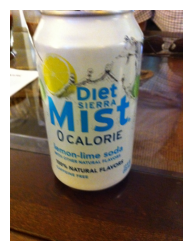

Question: What is this?
No OCR answer: diet sierra mist with a lemon slice on it
OCR answer: a bottle of diet sierra mist with a lemon slice on it


In [8]:
for image in test_samples:
  question = imgs_w_txt[image]['question']
  ocr_inputs = imgs_w_txt[image]['ocr']['text']

  plot_img(direc + image)

  print(f"Question: {question}")
  print(f"No OCR answer: {vqa_model.vqa(question, direc + image)}")
  print(f"OCR answer: {vqa_model.vqa_multiple_choice(question, direc + image, ocr_inputs)}")

### Inference using VizWiz test set
Here we will test the model with the test set.

It is important to note that we are gonna use the **val set** as our **test set**. This is because we need to know which images contain text and this information is only present if we use the val set. Note that we won't use this set during training.

#### Data preprocessing

In [9]:
# Load data
source = '/media/arnau/PEN/TFG/val/' # Test (val)
direc = './data/'
file = "vizwiz_skill_typ_val.csv"
data = pd.read_csv(direc + file)
cleaned_data = data.dropna(axis='columns')

# Clean data
interest_col = ["IMG", "QSN", "TXT"]
interest_data = cleaned_data[interest_col]
print(f"Dataset size: {interest_data.shape}")

# Filter images containing text
df_w_3vts = interest_data[interest_data["TXT"] >= 3]
imgs_w_txt = df_w_3vts["IMG"].to_list()
n_imgs_w_txt = df_w_3vts.shape[0]
print(f"Number of images containing text: {len(imgs_w_txt)}")

Dataset size: (2245, 3)
Number of images containing text: 1069


Load data from the original VizwizVQA dataset

In [10]:
train_json_qlty = './data/'

with open(train_json_qlty + "final_val.json", encoding='UTF-8') as json_file:
    data = json.load(json_file)
    data = data["val"]  
    
data_size = len(data)
print(f"Dataset size: {data_size}")

Dataset size: 4319


In [11]:
# Sample a data item
key = list(data.keys())[0]
value = list(data.values())[0]
print(f"{key}\n")
pprint.pprint(value)



VizWiz_val_00000000.jpg

{'answerable': 0.0,
 'flaws': [True, False, False, False, False, False, False, False],
 'question': 'Ok. There is another picture I hope it is a better one.',
 'recognizable': 1.0}


In [12]:
list_imgs_dts1 = interest_data["IMG"].to_list()
list_imgs_dts2 = list(data.keys())

print(f"Number of imgs: \n\t dataset1: {len(list_imgs_dts1)} \n\t dataset2: {len(list_imgs_dts2)}")



Number of imgs: 
	 dataset1: 2245 
	 dataset2: 4319


Now we check which images are common in both datasets (VizWizVQA and VisionSkills). The result will be the images that form our test set

In [13]:
# From the 1st dataset, array containing all images with text
arr_imgs_w_txt = np.array(imgs_w_txt, dtype=str)

# From the 2nd dataset, array containing all images
arr_imgs_dts2 = np.array(list_imgs_dts2, dtype=str)

# Images present in both datasets
common_imgs = list(set(list_imgs_dts1).intersection(list_imgs_dts2))
print(f"Intersection dataset size: {len(common_imgs)} imgs")

Intersection dataset size: 2245 imgs


In [ ]:
# How many imgs from the 1st dataset (txt) are also in the 2nd one?
total_imgs_w_txt = np.array(list(set(arr_imgs_w_txt).intersection(common_imgs)), 
                          dtype=str)

We write a json file that has all images containing text from the val (test in our case) set

In [14]:
# Save json file with all images containing text
names_imgs_w_txt = list(set(arr_imgs_w_txt).intersection(common_imgs))
json_imgs_w_txt = {img: data[img] for img in names_imgs_w_txt}

with open('./data/imgs_w_txt_val.json', 'w') as outfile:
    json.dump(json_imgs_w_txt, outfile)

#### Results

In [43]:
# Load json file containing test data
f = '/media/arnau/PEN/TFG/imgs_w_txt_val_ocr.json'
with open(f, encoding='UTF-8') as json_file:
    imgs_w_txt_val_ocr = json.load(json_file)

# Load groundtruth data
gt = './Annotations/val.json'
with open(gt, encoding='UTF-8') as json_file:
    val_gt = json.load(json_file)

Run the model for all images in the test set

In [44]:
test_res = {}

for image in imgs_w_txt_val_ocr:
  question = imgs_w_txt_val_ocr[image]['question']
  ocr_inputs = imgs_w_txt_val_ocr[image]['ocr']['text']
  ocr_google_inputs = imgs_w_txt_val_ocr[image]['ocr_google']['text']

  non_ocr_answer = vqa_model.vqa(question, direcv + image)

  if len(ocr_inputs) > 0:
    ocr_answer = vqa_model.vqa_multiple_choice(question, direcv + image, ocr_inputs)
  else:
    ocr_answer = []

  if len(ocr_google_inputs) > 0:
    ocr_google_answer = vqa_model.vqa_multiple_choice(question, direcv + image, 
                                                              ocr_google_inputs)
  else:
    ocr_google_answer = []

  info = { 'question' : question,
          'HF_OCR_google_answer' : ocr_google_answer,
          'HF_OCR_answer' : ocr_answer,
          'HF_NON_OCR_answer' :  non_ocr_answer      
          }

  test_res[image] = info


Add groundtruth answers and save results to json file

In [46]:
hf_model_test_res = test_res.copy()

for img_name1, _ in hf_model_test_res.items():
  for img_info in val_gt:
    img_name2 = img_info["image"]
    if img_name1 == img_name2:
      hf_model_test_res[img_name1]['gt_answers'] = img_info['answers']

Visualize a sample result

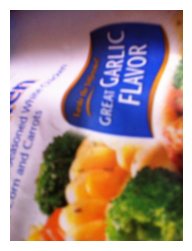

{'HF_NON_OCR_answer': 'broccoli and pasta',
 'HF_OCR_answer': 'broccoli and pasta',
 'HF_OCR_google_answer': 'great (8) GARLIC',
 'gt_answers': [{'answer': 'vegetables', 'answer_confidence': 'maybe'},
                {'answer': 'vegetables', 'answer_confidence': 'no'},
                {'answer': 'unanswerable', 'answer_confidence': 'yes'},
                {'answer': 'vegetables', 'answer_confidence': 'yes'},
                {'answer': 'vegetables', 'answer_confidence': 'maybe'},
                {'answer': 'vegetables', 'answer_confidence': 'yes'},
                {'answer': 'unanswerable', 'answer_confidence': 'no'},
                {'answer': 'corn carrots', 'answer_confidence': 'yes'},
                {'answer': 'mixed vegetables', 'answer_confidence': 'maybe'},
                {'answer': 'vegetable', 'answer_confidence': 'yes'}],
 'question': 'What is in this bag?'}


In [47]:
img_name = "VizWiz_val_00002859.jpg"
plot_img(direcv + img_name)
pprint.pprint(hf_model_test_res[img_name], compact=True)

In [48]:
# Save results
f = '/media/arnau/PEN/TFG/hf_model_test_res.json'
with open(f, 'w') as outfile:
    json.dump(hf_model_test_res, outfile)